# Regrid and plot curvilinear grid

Many ocean models are run on and archived on [_curvilinear_](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview) (as opposed to rectilinear or regular) grids.  Models are run on these grids to avoid singularities when solving the CFD equations.  For example, if a model was run on a regular grid, there would be a singularity at the north pole.  However, displaying data on curvilinear grids is sometimes challenging.  So the data needs to be regridded. 

It should be noted that regridding is not always conservative ([see here](https://drclimate.wordpress.com/2018/12/30/data-analysis-and-ocean-model-grids/).  So it is recommended to do any calculations on the native curvilinear grid (e.g. summing, calculating budgets, etc) before regridding.

I use [`xesmf`](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html), which integrates with [`xarray`](http://xarray.pydata.org/en/stable/index.html) and ['ESMFPy'](http://www.earthsystemmodeling.org/esmf_releases/public/ESMF_8_0_0/esmpy_doc/html/index.html) to regrid the data.  `xesmf` is a simple interface to `ESMFPy` and for some application, could be used to regrid data on it's own.  However, I have run into some issues with `xesmf` when regridding from an ocean tri-polar grid to the EASE-Grid. The EASE-Grid is another example of a curvilinear grid - at least in terms of the simple definition that it requires a 2-dimensional array of latitudes and 2-dimensional array of longitudes to define the position of each grid-cell.

`xarray` is a powerful and relatively straight forward tool to work with multi-dimensional arrays of data - e.g. GCM output.  I use `cartopy` to plot the data.

Further discussions of regridding can be found in the links below.

https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview  

https://www.ncl.ucar.edu/Applications/ESMF.shtml

https://xgcm.readthedocs.io/en/latest/index.html

http://www.earthsystemmodeling.org/esmf_releases/public/ESMF_8_0_0/esmpy_doc/html/index.html

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

# Load the data

I use sea ice concentration from the MRI-ESM2 model as an example.  `xarray` integrates with `dask`, which allows parallel computation on large datasets that cannot fit into memory.  So you can work with large model output arrays, even on a laptop. 

Clicking on the &#9658; beside attributes and looking for the __grid__ attribute will show that the sea ice is on a "native ocean tri-polar grid with 360x363 ocean cells".

In [2]:
filepath = 'siconc_SImon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.subset.nc'
ds = xr.open_dataset(filepath)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})  # xesmf only recognizes lon and lat
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, time: 12, vertices: 4, x: 360, y: 363)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
  * y                   (y) float64 -78.0 -77.5 -77.0 ... 149.7 151.8 154.0
  * x                   (x) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    lat                 (y, x) float64 ...
    lon                 (y, x) float64 ...
    type                |S7 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    y_bnds              (y, bnds) float64 ...
    x_bnds              (x, bnds) float64 ...
    vertices_latitude   (y, x, vertices) float64 ...
    vertices_longitude  (y, x, vertices) float64 ...
    siconc              (time, y, x) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-03T08:11:37Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MRI.MRI-ESM2...
    grid:                   native ocean tri-polar grid with 360x363 ocean cells
    grid_label:             gn
    history:                2019-09-03T08:11:37Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Meteorological Research Institute, Tsukuba, Ibara...
    institution_id:         MRI
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MRI-ESM2-0
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  seaIce
    source:                 MRI-ESM2.0 (2017): \naerosol: MASINGAR mk2r4 (TL9...
    source_id:              MRI-ESM2-0
    source_type:            AOGCM AER CHEM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               SImon
    table_info:             Creation Date:(24 July 2019) MD5:1d2f5276ed1d6eae...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/af962ff0-13d3-4b8b-b6bc-7b533a373109
    variable_id:            siconc
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0

We can plot the data to see what it looks like.  This is clearly not a regular grid.

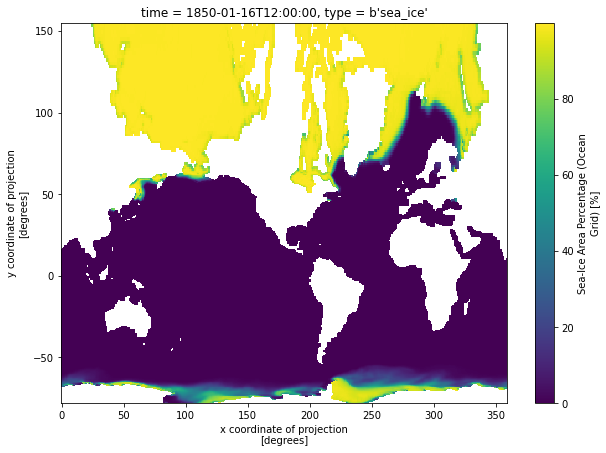

In [3]:
fig, ax = plt.subplots(figsize=(10,7))
ds.siconc[0,:,:].plot(ax=ax)

Plotting a selection of grid-points on a map shows that the grid is regular at middle latitudes in the northern hemisphere and throughout the southern hemisphere, albeit with irregular spacing.  However, the grid is not regular in the northern high latitudes.

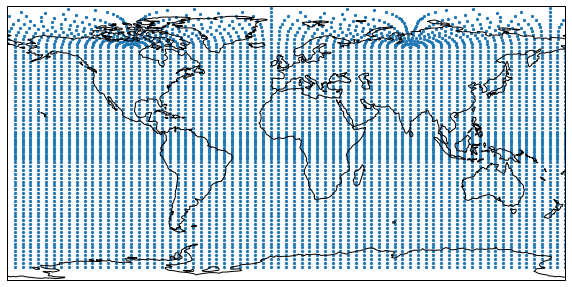

In [4]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.scatter(ds.lon[::5, ::5], ds.lat[::5, ::5], 20, marker='.', transform=ccrs.PlateCarree())
ax.coastlines()

Plotting points north of 50 &#176;N shows the two poles in the northern hemisphere; one over Arctic Canada and one in Siberia.

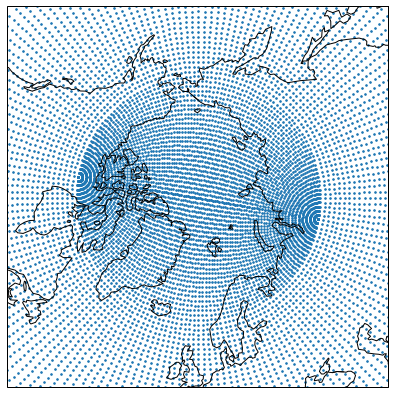

In [5]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180., 50., 90.], ccrs.PlateCarree())
ax.scatter(ds.lon[::2, ::2], ds.lat[::2, ::2], 10, marker='.', transform=ccrs.PlateCarree())
ax.coastlines()

For the purposes of illustration, we will regrid the data to a regular lat-lon grid with 0.5 degree spacing.  The grid is defined as an `xarray.Dataset` containing `lon` and `lat` variables.

In [6]:
ds_out = xr.Dataset({
    'lon': np.linspace(0,359.5,720),
    'lat': np.linspace(-89.5, 89.5, 360)
})
ds_out

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
  * lat      (lat) float64 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
Data variables:
    *empty*

An instance of the `xesmf.Regridder` onject is initiated by passing the original `xarray.Dataset` `ds` and `xarray.Dataset` containing the output grid definition.  I also set the regridding method to the _nearest neighbour_ method `nearest_s2d`.  `ESMF` provides two nearest neighbour methods: `nearest_s2d` and `nearest_d2s`.  In the first method, the each destination point is matched to the nearest source point.  In the second method, each source point is mapped to the nearest destination point.  See the [ESMF documention](http://www.earthsystemmodeling.org/esmf_releases/public/ESMF_8_0_0/ESMF_refdoc/node3.html#SECTION03023300000000000000) for more information.

In [7]:
regridder = xe.Regridder(ds, ds_out, 'nearest_s2d')
regridder

Overwrite existing file: nearest_s2d_363x360_360x720.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_363x360_360x720.nc 
Reuse pre-computed weights? False 
Input grid shape:           (363, 360) 
Output grid shape:          (360, 720) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

The `xesmf.Regridder` instance takes a 3-D (e.g. `(time, x, y)`) `xarray.DataArray` or an `xarray.Dataset` as an argument.  Here I pass the seaice `DataArray` `ds.siconc`. 

In [8]:
dr_out = regridder(ds.siconc)
dr_out

<xarray.DataArray 'siconc' (time: 12, lat: 360, lon: 720)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.67521667, 99.67521667, 99.67521667, ..., 99.67521667,
         99.67521667, 99.67521667],
        [99.67457581, 99.67457581, 99.67457581, ..., 99.67457581,
         99.67457581, 99.67457581],
        [99.57958221, 99.57958221, 99.57958221, ..., 99.57958221,
         99.57958221, 99.57958221]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.7545929 , 99.7545929 , 99.7545929 , ..., 99.7545929 ,
         99.7545929 , 99.7545929 ],
        [99.75737762, 99.75737762, 99.75737762, ..., 99.75737762,
         99.75737762, 99.75737762],
        [99.7122879 , 99.7122879 , 99.7122879 , ..., 99.7122879 ,
         99.7122879 , 99.7122879 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.67325592, 99.67325592, 99.67325592, ..., 99.67325592,
         99.67325592, 99.67325592],
        [99.65422058, 99.65422058, 99.65422058, ..., 99.65422058,
         99.65422058, 99.65422058],
        [99.71668243, 99.71668243, 99.71668243, ..., 99.71668243,
         99.71668243, 99.71668243]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [98.88049316, 98.88049316, 98.88049316, ..., 98.88049316,
         98.88049316, 98.88049316],
        [98.9608078 , 98.9608078 , 98.9608078 , ..., 98.9608078 ,
         98.9608078 , 98.9608078 ],
        [98.85879517, 98.85879517, 98.85879517, ..., 98.85879517,
         98.85879517, 98.85879517]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.49111176, 99.49111176, 99.49111176, ..., 99.49111176,
         99.49111176, 99.49111176],
        [99.45748901, 99.45748901, 99.45748901, ..., 99.45748901,
         99.45748901, 99.45748901],
        [99.25900269, 99.25900269, 99.25900269, ..., 99.25900269,
         99.25900269, 99.25900269]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.7069397 , 99.7069397 , 99.7069397 , ..., 99.7069397 ,
         99.7069397 , 99.7069397 ],
        [99.60795593, 99.60795593, 99.60795593, ..., 99.60795593,
         99.60795593, 99.60795593],
        [99.603302  , 99.603302  , 99.603302  , ..., 99.603302  ,
         99.603302  , 99.603302  ]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    type     |S7 b'sea_ice'
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0

As a check, we can plot the regridded field.  There are some artifacts in over Antarctica.  These could be masked out using a land-sea mask.

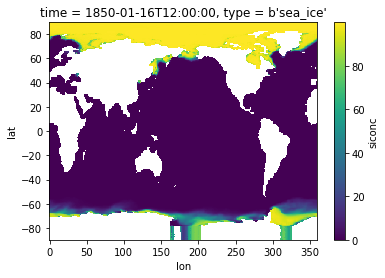

In [9]:
dr_out[0,:,:].plot()

## Plot the results on a map

Now that the data are in a regular lat-lon grid, they can be plotted on a map.  I use a combination of `matplotlib` and `cartopy` to do this.  The key difference between a normal `matplotlib` plot and a geographic coordinate aware plot is that we pass the projection information using the `projection` keyword argument when `matplotlib.axes` are generated.  This produces a `geoaxes` object.  In this case, I use the [_Plate Carree_](https://en.wikipedia.org/wiki/Equirectangular_projection).  Strictly, _Plate Carree_ is not a map projection but just a cartesian grid, where x and y axes are latitudes and longitudes. 

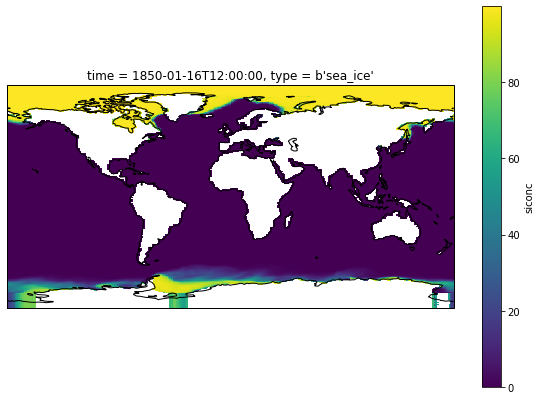

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
dr_out[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

To see the Arctic ocean in more detail, the data can be displayed on a [_North Polar Stereographic_](https://nsidc.org/data/polar-stereo/ps_grids.html#:~:text=NSIDC's%20polar%20stereographic%20projection%20specifies,degrees%20northern%20and%20southern%20latitude.&text=Since%20there%20is%20a%20one,no%20distortion%20at%20the%20pole.) projection.  Many Arctic Ocean and Arctic-centric satellite products are available on the North Polar Stereographic projection.  Note, the North Polar Stereographic projection is not an equal-area projection, so an area-weighting needs to be used to calculate area means and sums.

`cartopy` has a large number of [map projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html).  Note that `ax.set_extent` and the plot call need to be told the projection or the data they are passed.  In this case the data are latitudes and longitudes in _Plate Carree_.

Standard `matplotlib.pyplot.axes` methods can be called to modify the plot.

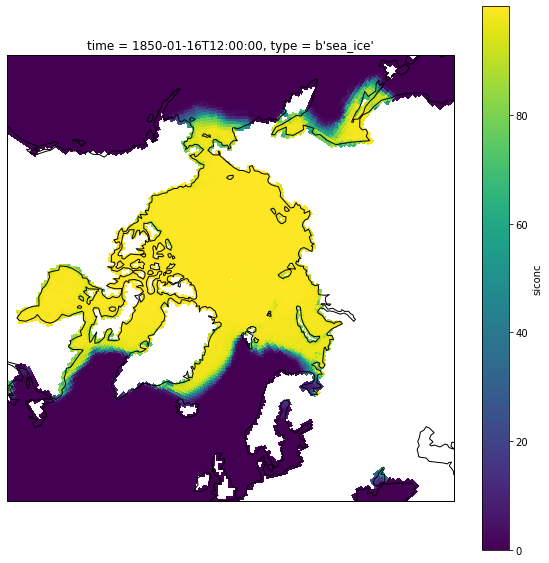

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
dr_out[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

## Regridding to EASE-Grid

The [EASE-Grids](https://nsidc.org/data/ease) were developed at NSIDC for raster data.  They are grids on an Equal-Area projections, so that area means and sums can be calculated without having to weight grid-cell values by area.   Northern and southern hemisphere grids are on _Lambert's Equal-Area Azimuthal_ projections.  There are two versions of EASE-Grids; the original _EASE-Grid_, which uses a spherical datum; and _EASE-Grid 2.0_, which uses WGS84 (an ellipsoid).  This is important, because most climate models use a spherical Earth model.  Reprojecting data from a projection that uses one datum to another projection that uses another datum, requires a datum shift.  The latitudes and longitude of a location on the Earth surface is dependent on the [datum](https://en.wikipedia.org/wiki/Geodetic_datum#Geodetic_versus_geocentric_latitude). So, if GCM output is regridded to a grid on projected coordinate system using `xesmf` or `ESMFPy`, which map coordinates using latitude and longitude, the original EASE-Grid should be used because it, like GCM grids, assumes a spherical earth.  

I have defined the EASE-Grid North projection and grid in the maps module of [`apbplotlib`](https://github.com/andypbarrett/apbplotlib).  This can be installed directly from GitHub using 

`$ pip install git+https://github.com/andypbarrett/apbplotlib`

__\*\*__ Note below, I still use EASE2_North, which is fine for plotting (I think).  I need to figure out some issues with EASE_Grid.  You could also use `cartopy.crs.NorthPolarStereo()` and `xesmf`.  

In [12]:
from apbplotlib.maps import EASE_North, EASE2_North

### Define output EASE-Grid 2.0 North grid
Even though the projection is defined, the resolution of the destination grid needs to be defined, and the latitudes and longitudes of each grid cell need to be calculated.  For the purposes of this example, I define a 50 km grid.  An alternative approach is to download the latitude and longitude arrays from [NSIDC](https://nsidc.org/data/ease/tools#geo_data_files). 

In [13]:
proj_out = EASE2_North()  # output grid

xmin, xmax = proj_out.x_limits  # x and y limits of EASE-Grid North are attributes of EASE_North class 
ymin, ymax = proj_out.y_limits
dx = dy = 50000.  # grid resolution in meters
x = np.arange(xmin+dx/2., xmax-dx/2., dx)  
y = np.arange(ymin+dy/2., ymax-dy/2., dy)
x2d, y2d = np.meshgrid(x, y)  # Generate 2D arrays

proj_tmp = ccrs.PlateCarree() 
grid_out = proj_tmp.transform_points(proj_out, x2d, y2d)  # Convert x and y in projected coordinates to lat, lon
lon2d, lat2d = grid_out[:,:,0], grid_out[:,:,1]
lon2d = np.where(lon2d < 0., 360 + lon2d, lon2d)  # transfor_points return longitudes with range -180 to 180, convert to 0 to 360.

Just to check how the grid looks, plot it.  

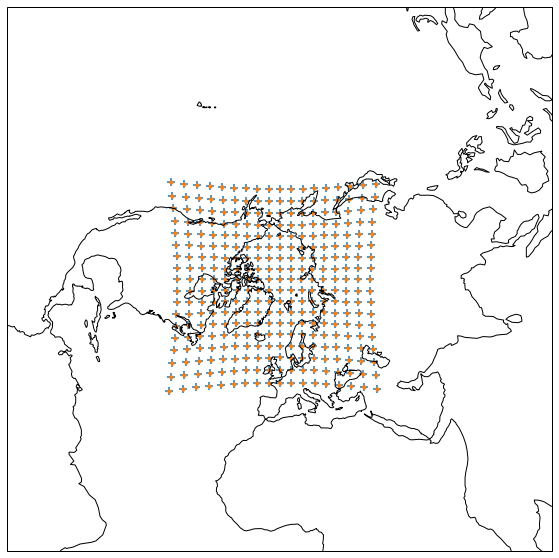

In [14]:
every = 10  # stride for plotting array points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 0., 90.], ccrs.PlateCarree())
ax.scatter(lon2d[::every, ::every], lat2d[::every, ::every], 50, marker='+', transform=proj_tmp)
ax.scatter(x2d[::every, ::every], y2d[::every, ::every], 10, transform=proj_out)
ax.coastlines()

### Regrid using `xesmf`

_I have found the problem with using `xesmf` to regrid to EASE-Grid 2.0 - This was a plotting issue not an issue with regridding.  See __Plot Regridded Data__ below for further explanation_ 

`xesmf` is both a simpler and more efficient method than using `ESMF` directly.  My preference is use use `xesmf` but there may be cases when `xesmf` doesn't do what you want.

The steps to regrid to EASE-Grid 2.0 North are the same used above.

1) Define the output grid  \
2) Initialise the `xesmf.Regridder` object  \
3) Run the `regridder` function on the field of interest


#### Define output grid

In [15]:
ease2N = xr.Dataset({
    'lat': (['x', 'y'], lat2d),
    'lon': (['x', 'y'], lon2d),
})

#### Initialize `xesmf.Regridder` 

In [16]:
regridder = xe.Regridder(ds, ease2N, 'nearest_s2d')
regridder

/home/apbarret/anaconda3/envs/xesmf_env_test/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: nearest_s2d_363x360_179x179.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_363x360_179x179.nc 
Reuse pre-computed weights? False 
Input grid shape:           (363, 360) 
Output grid shape:          (179, 179) 
Output grid dimension name: ('x', 'y') 
Periodic in longitude?      False

#### Regrid `siconc` field

In [17]:
ds_regrid = regridder(ds.siconc)
ds_regrid

<xarray.DataArray 'siconc' (time: 12, x: 179, y: 179)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
    type     |S7 b'sea_ice'
    lon      (x, y) float64 315.0 315.3 315.6 316.0 ... 136.0 135.7 135.3 135.0
    lat      (x, y) float64 30.55 30.92 31.28 31.64 ... 32.37 32.01 31.65 31.28
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d

#### Plot Regridded Data

The regridded data are plotted below to check regridding.  A slightly different plot call is used than above.  The reason for this is that the default plotting method for 2D arrays is `xarray.DataArray.plot.pcolormesh`.  By default, `pcolormesh` uses `darray.dims[0]` and `darray.dims[1]` as the plot coordinates.

In [18]:
ds_regrid[0,:,:].dims

('x', 'y')

For `ds_regrid`, these dimensions are `x` and `y` but there is no coordinate data for these dimensions.   There are two solutions.  The first is to pass the names of coordinates to `pcolormesh`: example 1 below.  The second solution is to add coordinate data to the `DataArray`.  This second solution is preferred, especially if the regridded data will be written to a file.

In [19]:
ds_regrid.coords['x'] = x
ds_regrid.coords['y'] = y

Text(0.5, 1.0, 'Example 2: add x and y as coordinates')

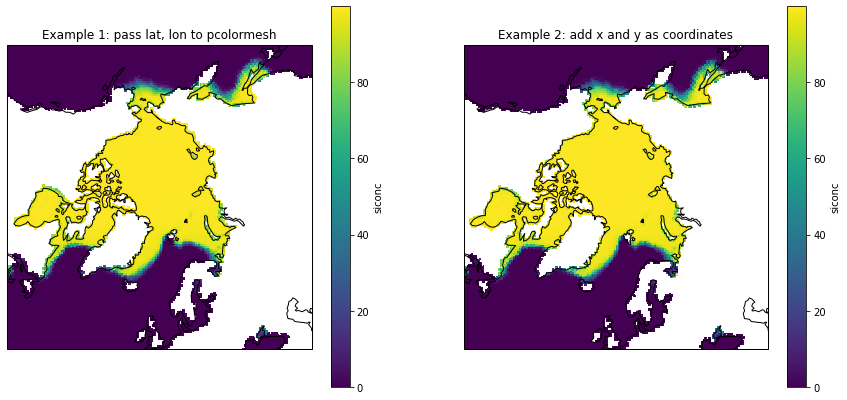

In [20]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
ds_regrid[0,:,:].plot.pcolormesh('lon', 'lat', ax=ax1, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Example 1: pass lat, lon to pcolormesh')

ax2 = fig.add_subplot(122, projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
ds_regrid[0,:,:].plot(ax=ax2, transform=proj_out)
ax2.coastlines()
ax2.set_title('Example 2: add x and y as coordinates')

### Regrid using ESMF

__This is not needed now but might be useful for dealing with grids to do not play well with `xesmf`__

As noted above, while `xesmf` is a nice simplified interface to `ESMFPy`, there see to be some issues with regridding between curvilinear grids.  So I use `ESMFPy`, which is what is used "under-the-hood" of `xesmf`.  Actually, `ESMFPy` uses ESMF which is Fortran code.  The procedure is a little more complicated but can be written as a function.

In [21]:
import ESMF

The first step is to initialise source and desctination grid objects.  `ESMF.Grid` objects contain the grid definitions.  Three bits of information are required: 1) the shape of the grids; 2) the location of the grid coordinates - in this case it is the grid centers but it could be the apexes of grid cells; 3) the type of coordinate system used - here both spherical\*.  The coordinate arrays must be transposed because the underlying Fortran code requires Fortran ordered and not C-ordered arrays.  Numpy arrays are C-ordered.

\* It occurs to me that the `coord_sys` keyword argument could be used if the destination grid were on an ellipsoidal datum. 

In [22]:
sourcegrid = ESMF.Grid(np.array(ds.lat.T.shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)
destgrid = ESMF.Grid(np.array(lat2d.T.shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)

/home/apbarret/anaconda3/envs/xesmf_env_test/lib/python3.7/site-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


Next latitude and longitude coordinates for source and destination grids are assigned to `sourcegrid` and `destgrid`.

In [23]:
source_lon = sourcegrid.get_coords(0)
source_lat = sourcegrid.get_coords(1)
source_lon[...] = ds.lon.T
source_lat[...] = ds.lat.T

dest_lon = destgrid.get_coords(0)
dest_lat = destgrid.get_coords(1)
dest_lon[...] = lon2d.T
dest_lat[...] = lat2d.T

Next, source and destination fields are defined.  `ESMF.Field` objects contain the data values.

In [24]:
sourcefield = ESMF.Field(sourcegrid, name='Source')
destfield = ESMF.Field(destgrid, name='Destination')

The `ESMF.Regrid` object is then initialised.  This object contains, among other things, the weights and mappings between the source and destination grids, essentially a sparse matrix.

In [25]:
regrid = ESMF.Regrid(sourcefield, destfield, 
                     regrid_method=ESMF.RegridMethod.NEAREST_STOD,
                     unmapped_action=ESMF.UnmappedAction.IGNORE,)

`regrid` is then used to regrid a field.  Currently, this code regrids the first field in the 3D array.  A loop could be added to regrid all timesteps.

In [26]:
tmpOut = []
for t in ds.time:
    #sourcefield.data[...] = ds.siconc[0,:,:].T.values
    sourcefield.data[...] = ds.siconc.sel(time=t).T.values
    destfield = regrid(sourcefield, destfield)
    tmpOut.append(destfield.data.T)

In [27]:
ds_regrid = xr.Dataset({
    'siconc': (['time', 'x', 'y'], np.stack(tmpOut)),
},
    coords = {
        'x': (['x'], x),
        'y'
        'lat': (['x', 'y'], lat2d),
        'lon': (['x', 'y'], lon2d),
        'time': (['time'], ds.time),
    }
)
ds_regrid

<xarray.Dataset>
Dimensions:  (time: 12, x: 179, y: 179)
Coordinates:
  * x        (x) float64 -4.475e+06 -4.425e+06 ... 4.375e+06 4.425e+06
    ylat     (x, y) float64 30.55 30.92 31.28 31.64 ... 32.37 32.01 31.65 31.28
    lon      (x, y) float64 315.0 315.3 315.6 316.0 ... 136.0 135.7 135.3 135.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
Dimensions without coordinates: y
Data variables:
    siconc   (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Lastly, plot the output data

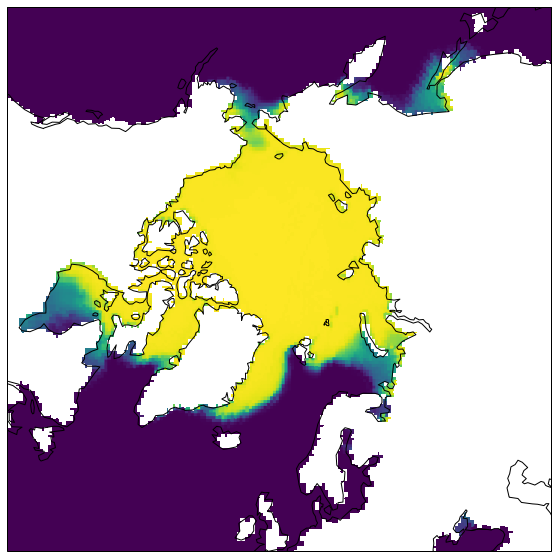

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
#ds_regrid.siconc[0,:,:].plot(ax=ax, transform=proj_out)
ax.imshow(ds_regrid.siconc[0,:,:].values, extent=list(proj_out.x_limits) + list(proj_out.y_limits), transform=proj_out)
ax.coastlines()